In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import funcs
import imp
import random
imp.reload(funcs)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3224\237948753.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
exp_info = funcs.load_info()
rpm_answers = funcs.load_rpm_answers()
subjects_behavior = funcs.load_subjects_behavior()

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\funcs.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  subjects_behavior = pd.concat([subjects_behavior, one_behavior], ignore_index=True)


### Accuracy

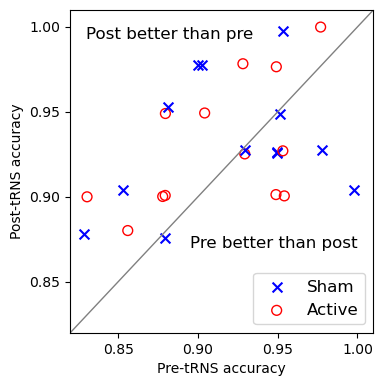

In [3]:
# accuracy
task_times = ['pre', 'post']
subjects_accuracy = np.empty([26, 2]) # 26 subjects, 2 task times

for subject_id in range (1,27):
    for task_time in range(2): # 0=pre and 1=post
        filtered_rows = subjects_behavior[
            (subjects_behavior['subject id'] == subject_id) &
            (subjects_behavior['task time'] == task_times[task_time])
        ]
        corrects = filtered_rows['correct'].sum()
        subjects_accuracy[subject_id-1, task_time] = corrects / len(filtered_rows)

# plot
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10*cm, 10*cm))
markersize = 50
for subject_id in range(1,27):
    fluc_level = 0.003
    fluc_x, fluc_y = random.uniform(-1*fluc_level, fluc_level), random.uniform(-1*fluc_level, fluc_level)
    # fluc_x, fluc_y = 0, 0
    isActive = 1 if exp_info[exp_info['subject id'] == subject_id]['Condition'].iloc[0] == 'Active' else 0
    coord = subjects_accuracy[subject_id-1, :]
    # ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=50, c='red' if isActive else 'blue', marker='o' if isActive else 'x')
    if isActive:
        ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=markersize, edgecolors='red', facecolors='none', marker='o', label='Active' if subject_id == 2 else "")
    else:
        ax.scatter(coord[0]+fluc_x, coord[1]+fluc_y, s=markersize, color='blue', marker='x', label='Sham' if subject_id == 1 else "")

# Plot line from (0,0) to (1,1)
matplotlib.rcParams.update({'font.size': 12})
ax.plot([0, 1.1], [0, 1.1], color='grey', linewidth=1)
ax.text(0.83, 0.993, 'Post better than pre', fontsize=12)
ax.text(0.895, 0.87, 'Pre better than post', fontsize=12)

ax.set_xlim([0.82, 1.01])
ax.set_ylim([0.82, 1.01])

# ax.set_xlim([0.7, 1.01])
# ax.set_ylim([0.7, 1.01])

ax.set_xticks((0.85, 0.9, 0.95, 1.0))
ax.set_yticks((0.85, 0.9, 0.95, 1.0))
ax.set_xlabel('Pre-tRNS accuracy')
ax.set_ylabel('Post-tRNS accuracy')
ax.legend(loc='lower right', fontsize=12)
# Adjust layout and margins
# plt.tight_layout(pad=1.0)
fig.subplots_adjust(left=0.2, bottom=0.14, right=0.97, top=0.96)
# plt.title(fig_title, pad=3)
save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'coord_prepost_all.png')
# plt.savefig(save_path, format='png', dpi=600)

plt.show()

### Reaction time

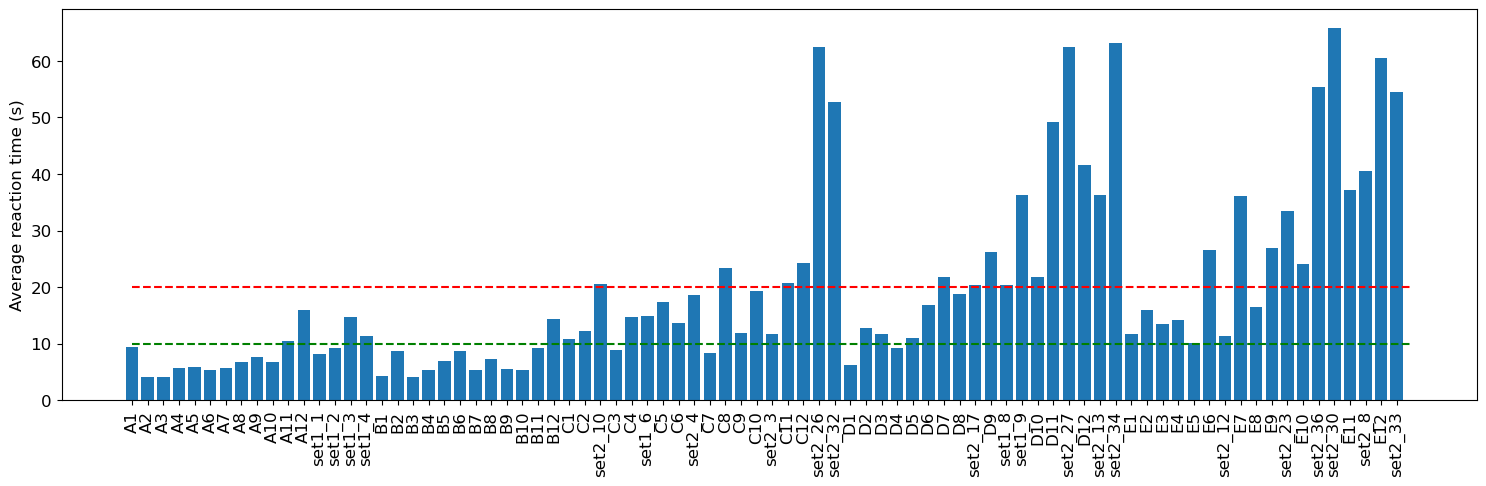

In [4]:
rpm_difficulty = pd.DataFrame(columns=['question', 'average time', 'difficulty'])
rpm_difficulty['question'] = rpm_answers['question'][0:82]
df = subjects_behavior[(subjects_behavior['reaction time'] != 0) & (subjects_behavior['task time'] == 'pre')]
for i in range(82):
    question_index = rpm_difficulty['question'][i]
    rts = df[df['question'] == question_index]['reaction time']
    rpm_difficulty['average time'][i] = rts.mean()
    

fig = plt.figure(figsize=(15, 5))
plt.bar(rpm_difficulty['question'], rpm_difficulty['average time'])
plt.xticks(rotation=90)
plt.hlines(10, 0, 82, colors='g', linestyles='dashed')
plt.hlines(20, 0, 82, colors='r', linestyles='dashed')

plt.ylabel('Average reaction time (s)')

plt.tight_layout(pad=1.0)

save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'rt_bar_question.png')
# plt.savefig(save_path, format='png', dpi=600)
plt.show()

# 3-level difficulty
count1 = (rpm_difficulty['average time'] < 10).sum()
count2 = ((rpm_difficulty['average time'] >= 10) & (rpm_difficulty['average time'] < 20)).sum() 
count3 = (rpm_difficulty['average time'] > 20).sum()

# 4-level difficulty
# count1 = (rpm_difficulty['average time'] < 8).sum()
# count2 = ((rpm_difficulty['average time'] >= 8) & (rpm_difficulty['average time'] < 13)).sum() 
# count3 = ((rpm_difficulty['average time'] >= 13) & (rpm_difficulty['average time'] < 23)).sum()
# count4 = (rpm_difficulty['average time'] > 23).sum()


In [5]:
task_times = ['pre', 'post']
conditions = ['Sham', 'Active']
df = subjects_behavior[subjects_behavior['reaction time'] != 0]

rt_table = pd.DataFrame(columns=['question', 'condition', 'task time', 'average time', 'STD', 'SEM'])
# rt_table['question'] = rpm_answers['question'][0:82]
df = subjects_behavior[(subjects_behavior['reaction time'] != 0)]

for i in range(82):
    for condition in conditions:    
        for task_time in task_times:
                df_filtered = df[
                    (df['question'] == rpm_answers['question'][i]) &
                    (df['condition'] == condition) &
                    (df['task time'] == task_time)
                ]
                rts = df_filtered['reaction time']
                one_row = {
                    'question': rpm_answers['question'][i],
                    'condition': condition,
                    'task time': task_time,
                    'average time': rts.mean(),
                    'STD': np.nan_to_num(rts.std(), nan=0),
                    'SEM': np.nan_to_num(rts.sem(), nan=0)
                }
                rt_table = pd.concat([rt_table, pd.DataFrame([one_row])])


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3224\2222945695.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rt_table = pd.concat([rt_table, pd.DataFrame([one_row])])


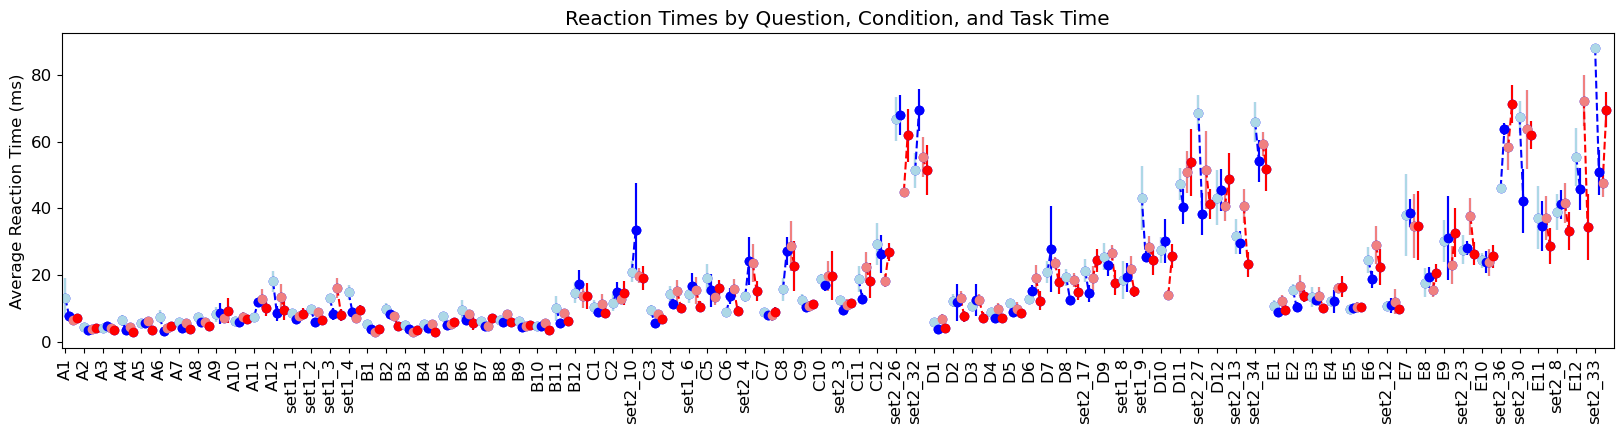

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rt_table is already created and contains the necessary data.
# Extract unique questions to plot
questions = rt_table['question'].unique()
num_questions = len(questions)

# Colors for different conditions and times
# colors = {
#     ('Sham', 'pre'): 'lightblue',
#     ('Sham', 'post'): 'blue',
#     ('Active', 'pre'): 'lightcoral',
#     ('Active', 'post'): 'red'
# }
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# Initialize plot
fig, ax = plt.subplots(figsize=(num_questions * 0.2, 4.5))  # Adjusting width for each question

# Iterate over each question to plot the mean and error bars
for idx, question in enumerate(questions):
    subset = rt_table[rt_table['question'] == question]
    
    # Sort subset to ensure consistent order [Sham pre, Sham post, Active pre, Active post]
    subset = subset.sort_values(by=['condition', 'task time'], ascending=[False, False])

    # Collect means, std errors, and labels
    means = subset['average time'].values
    std_errors = subset['SEM'].values  # using SEM for error bars
    # labels = [f'{cond} {time}' for cond, time in zip(subset['condition'], subset['task time'])]

    # Plot data points and connect lines within each condition
    x_vals = np.arange(len(means)) + idx * (len(means) + 1)  # Offset each group of points
    
    ax.errorbar(x_vals, means, yerr=std_errors, fmt='o', color='blue')
    for i in range (0,4):
        ax.errorbar(x_vals[i], means[i], yerr=std_errors[i], marker='o', color=colors[i])

    ax.plot(x_vals[0:2], means[0:2], color='blue', linestyle='--')  # Connect Sham points
    ax.plot(x_vals[2:4], means[2:4], color='red', linestyle='--')  # Connect Active points

# Adjust x-axis
ax.set_xlim(-1, num_questions * (len(means) + 1))
ax.set_xticks(range(0, num_questions * (len(means) + 1), len(means) + 1))
ax.set_xticklabels(questions, rotation=90)

# Add labels and title
ax.set_ylabel('Average Reaction Time (ms)')
ax.set_title('Reaction Times by Question, Condition, and Task Time')

# Adjust layout to make room for labels
fig.tight_layout()

save_path = os.path.join('..', '..', '..', 'paper', 'behavior', 'rt_question_condition_tasktime.png')
# plt.savefig(save_path, format='png', dpi=600)
plt.show()


In [7]:
# Define the conditions for the 'difficulty' values
conditions = [
    (rpm_difficulty['average time'] < 10),
    (rpm_difficulty['average time'] >= 10) & (rpm_difficulty['average time'] <= 20),
    (rpm_difficulty['average time'] > 20)
]

# Define the corresponding values to assign under each condition
choices = [1, 2, 3]

# Apply the conditions and choices to the 'difficulty' column
rpm_difficulty['difficulty'] = np.select(conditions, choices)
# rpm_difficulty

In [8]:
# conditions = [
#     (rpm_difficulty['average time'] < 8),
#     (rpm_difficulty['average time'] >= 8) & (rpm_difficulty['average time'] < 13),
#     (rpm_difficulty['average time'] >= 13) & (rpm_difficulty['average time'] < 23),
#     (rpm_difficulty['average time'] > 23)
# ]
# # Define the corresponding values to assign under each condition
# choices = [1, 2, 3, 4]

# # Apply the conditions and choices to the 'difficulty' column
# rpm_difficulty['difficulty'] = np.select(conditions, choices)
# rpm_difficulty

In [9]:
def plot_reaction_times(means, std, sem, fig_title):  
    # Bar chart
    labels = ['Pre-\nsham', 'Post-\nsham', 'Pre-\nactive', 'Post-\nactive']
    colors = ['lightblue', 'blue', 'lightcoral', 'red']

    # Plotting
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(6*cm, 6*cm))

    # Plotting error bars
    for i in range(4):
        ax.errorbar([labels[i]], [means[i]], yerr=[sem[i]], color=colors[i], marker='o', linestyle='-')

    # Add a line between means[0] and means[1]
    ax.plot(labels[0:2], means[0:2], color='blue', linestyle='--')

    # Add another line connecting means[2] and means[3]
    ax.plot(labels[2:4], means[2:4], color='red', linestyle='--')

    # Add some additional formatting if desired
    ax.set_ylabel('Reaction Time (s)')
    ax.set_title(fig_title)
    # ax.set_yticks(np.arange(ylim[0], ylim[1]+20, 20))
    matplotlib.rcParams.update({'font.size': 10})

    # Adjust layout and margins
    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(left=0.22, bottom=0.18, right=0.93, top=0.91)
    plt.title(fig_title, pad=4)
    save_path = os.path.join('..', '..', '..', 'paper', 'behavior', fig_title + '.png')
    # plt.savefig(save_path, format='png', dpi=600)
    plt.show()

### ANOVA

In [10]:
def fvalue_to_p(fvalue, df_num, df_denom):
    return 1 - stats.f.cdf(fvalue, df_num, df_denom)

difficulties = choices
difficulty_names = ['Easy', 'Medium', 'Hard']
# 3-way ANOVA
# Ensure the 'difficulty' column exists and is initialized to 0
subjects_behavior['difficulty'] = 0
for i, difficulty_name in enumerate(difficulty_names):
    difficulty_questions = rpm_difficulty[rpm_difficulty['difficulty'] == (i+1)]['question']
    mask = subjects_behavior['question'].isin(difficulty_questions)
    subjects_behavior.loc[mask, 'difficulty'] = difficulty_name

anova_table = subjects_behavior.copy()
anova_table.rename(columns={'task time': 'task_time'}, inplace=True)
anova_table.rename(columns={'reaction time': 'reaction_time'}, inplace=True)
# Assuming df is your DataFrame
# Ensure correct data types
anova_table['reaction_time'] = anova_table['reaction_time'].astype('int')

anova_table['condition'] = anova_table['condition'].astype('category')
anova_table['task_time'] = anova_table['task_time'].astype('category')
anova_table['difficulty'] = anova_table['difficulty'].astype('category')


# Fit the model
model = ols('reaction_time ~ C(condition) * C(task_time) * C(difficulty)', data=anova_table).fit()

# Perform ANOVA
anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# drop residuals row
# anova_results = anova_results.drop('Residual')

# Calculate Eta Squared
anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])
anova_results['p'] = anova_results.apply(lambda row: fvalue_to_p(row['F'], row['df'], 26), axis=1)
anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(2120/26), axis=1)
# anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(2120/(26-11)), axis=1)

# Display the results including F-values, p-values, and eta squared values
print((1-0.15-0.11-0.01-0.18-0.01-0.01)/2)
anova_results

    

0.265


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3224\3378781938.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Easy' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  subjects_behavior.loc[mask, 'difficulty'] = difficulty_name


,sum_sq,df,F,PR(>F),eta_sq,p,mod eta_sq
C(condition),1176.510885,1.0,6.622805,1.013551e-02,0.001920,1.612137e-02,0.156532
C(task_time),889.694028,1.0,5.008258,2.533016e-02,0.001452,3.401086e-02,0.118371
C(difficulty),232454.426387,2.0,654.265256,5.029360e-222,0.379299,1.110223e-16,30.927432
C(condition):C(task_time),87.389701,1.0,0.491933,4.831431e-01,0.000143,4.892969e-01,0.011627
C(condition):C(difficulty),1415.080016,2.0,3.982878,1.877152e-02,0.002309,3.098252e-02,0.188273
C(task_time):C(difficulty),77.068264,2.0,0.216916,8.050154e-01,0.000126,8.064397e-01,0.010254
C(condition):C(task_time):C(difficulty),144.807668,2.0,0.407575,6.653136e-01,0.000236,6.694382e-01,0.019266
Residual,376608.248379,2120.0,NaN,NaN,0.614516,NaN,50.106707


In [11]:
anova_table = subjects_behavior[subjects_behavior['difficulty'] == 'Easy'].copy()
anova_table.rename(columns={'task time': 'task_time'}, inplace=True)
anova_table.rename(columns={'reaction time': 'reaction_time'}, inplace=True)
# Assuming df is your DataFrame
# Ensure correct data types
anova_table['reaction_time'] = anova_table['reaction_time'].astype('int')

anova_table['condition'] = anova_table['condition'].astype('category')
anova_table['task_time'] = anova_table['task_time'].astype('category')

# Fit the model
model = ols('reaction_time ~ C(condition) * C(task_time)', data=anova_table).fit()

# Perform ANOVA
anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# drop residuals row
# anova_results = anova_results.drop('Residual')

# Calculate Eta Squared
anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])
anova_results['p'] = anova_results.apply(lambda row: fvalue_to_p(row['F'], row['df'], 26), axis=1)
anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(698/26), axis=1)

# Display the results including F-values, p-values, and eta squared values
print((1-0.166-0.0348)/2)

anova_results

0.39959999999999996


,sum_sq,df,F,PR(>F),eta_sq,p,mod eta_sq
C(condition),50.884615,1.0,4.530775,3.364013e-02,0.006185,0.042930,0.166051
C(task_time),326.011939,1.0,29.028160,9.762668e-08,0.039628,0.000012,1.063868
C(condition):C(task_time),10.687711,1.0,0.951636,3.296413e-01,0.001299,0.338293,0.034877
Residual,7839.157900,698.0,NaN,NaN,0.952887,NaN,25.581358


In [12]:
anova_table = subjects_behavior[subjects_behavior['difficulty'] == 'Medium'].copy()

anova_table.rename(columns={'task time': 'task_time'}, inplace=True)
anova_table.rename(columns={'reaction time': 'reaction_time'}, inplace=True)
# Assuming df is your DataFrame
# Ensure correct data types
anova_table['reaction_time'] = anova_table['reaction_time'].astype('int')
anova_table['condition'] = anova_table['condition'].astype('category')
anova_table['task_time'] = anova_table['task_time'].astype('category')

# Fit the model
model = ols('reaction_time ~ C(condition) * C(task_time)', data=anova_table).fit()

# Perform ANOVA
anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# drop residuals row
# anova_results = anova_results.drop('Residual')

# Calculate Eta Squared
anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])
anova_results['p'] = anova_results.apply(lambda row: fvalue_to_p(row['F'], row['df'], 26), axis=1)
anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(699/26), axis=1)


# Display the results including F-values, p-values, and eta squared values
anova_results

,sum_sq,df,F,PR(>F),eta_sq,p,mod eta_sq
C(condition),1.994441,1.0,0.037355,0.846801,0.000052,0.848246,0.001410
C(task_time),523.477177,1.0,9.804458,0.001813,0.013763,0.004270,0.370011
C(condition):C(task_time),188.993768,1.0,3.539756,0.060330,0.004969,0.071157,0.133587
Residual,37320.834708,699.0,NaN,NaN,0.981216,NaN,26.379607


### ANOVA hard level

In [13]:
# ANOVA
def make_anova_table(pre_sham, post_sham, pre_active, post_active, difficulty):
    df = pd.DataFrame(columns=['condition', 'task_time', 'difficulty', 'reaction_time'])
    # Create a new DataFrame for the new rows to be inserted
    new_rows = pd.DataFrame({
        'condition': ['sham'] * len(pre_sham),    # Repeat 'sham' for the length of rt_sham_before
        'task_time': ['pre'] * len(pre_sham),   # Repeat 'pre' for the same length
        'difficulty': [difficulty] * len(pre_sham),  # Repeat 'endo valid' for the same length
        'reaction_time': pre_sham                        # Reaction times
    })
    df = pd.concat([df, new_rows], ignore_index=True)

    new_rows = pd.DataFrame({
        'condition': ['sham'] * len(post_sham),    # Repeat 'sham' for the length of rt_sham_before
        'task_time': ['post'] * len(post_sham),   # Repeat 'pre' for the same length
        'difficulty': [difficulty] * len(post_sham),  # Repeat 'endo valid' for the same length
        'reaction_time': post_sham                        # Reaction times
    })
    df = pd.concat([df, new_rows], ignore_index=True)

    new_rows = pd.DataFrame({
        'condition': ['active'] * len(pre_active),    # Repeat 'sham' for the length of rt_sham_before
        'task_time': ['pre'] * len(pre_active),   # Repeat 'pre' for the same length
        'difficulty': [difficulty] * len(pre_active),  # Repeat 'endo valid' for the same length
        'reaction_time': pre_active                        # Reaction times
    })
    df = pd.concat([df, new_rows], ignore_index=True)

    new_rows = pd.DataFrame({
        'condition': ['active'] * len(post_active),    # Repeat 'sham' for the length of rt_sham_before
        'task_time': ['post'] * len(post_active),   # Repeat 'pre' for the same length
        'difficulty': [difficulty] * len(post_active),  # Repeat 'endo valid' for the same length
        'reaction_time': post_active                        # Reaction times
    })
    df = pd.concat([df, new_rows], ignore_index=True)

    return df


def fvalue_to_p(fvalue, df_num, df_denom):
    return 1 - stats.f.cdf(fvalue, df_num, df_denom)


difficulties = choices
difficulty_names = ['Easy', 'Medium', 'Hard']
#                       pres,posts,prea,posta  
outliers_k1 = np.array([[5, 5, 5, 5], # low_k
                        [1, 5, 5, 5]]) # high_k
ourliers_k2 = np.array([[1.5, 5, 5, 5], 
                        [5, 5, 1.5, 5]])
outliers_k3 = np.array([[1, 1, 1, 5], 
                        [5, 5, 5, 1.2]])

subset_questions = rpm_difficulty[rpm_difficulty['difficulty'] == 3] # hard questions
matching_rows = subjects_behavior[subjects_behavior['question'].isin(subset_questions['question'])]
subset_rts = matching_rows[matching_rows['correct'] == 1]

pre_sham_rts = subset_rts[(subset_rts['condition'] == 'Sham') & (subset_rts['task time'] == 'pre')]['reaction time']
post_sham_rts = subset_rts[(subset_rts['condition'] == 'Sham') & (subset_rts['task time'] == 'post')]['reaction time']
pre_active_rts = subset_rts[(subset_rts['condition'] == 'Active') & (subset_rts['task time'] == 'pre')]['reaction time']
post_active_rts = subset_rts[(subset_rts['condition'] == 'Active') & (subset_rts['task time'] == 'post')]['reaction time']

outlier_k = outliers_k3
pre_sham_rts = funcs.remove_outliers(pre_sham_rts, low_k=outlier_k[0,0], high_k=outlier_k[1,0], verbose=True)
post_sham_rts = funcs.remove_outliers(post_sham_rts, low_k=outlier_k[0,1], high_k=outlier_k[1,1], verbose=True)
pre_active_rts = funcs.remove_outliers(pre_active_rts, low_k=outlier_k[0,2], high_k=outlier_k[1,2], verbose=True)
post_active_rts = funcs.remove_outliers(post_active_rts, low_k=outlier_k[0,3], high_k=outlier_k[1,3], verbose=True)

anova_table = make_anova_table(pre_sham_rts, post_sham_rts, pre_active_rts, post_active_rts, 'Hard')
anova_table = pd.concat([anova_table, anova_table]).reset_index(drop=True)
# Assuming df is your DataFrame
# Ensure correct data types
# anova_table['reaction_time'] = anova_table['reaction_time'].astype('int')

anova_table['condition'] = anova_table['condition'].astype('category')
anova_table['task_time'] = anova_table['task_time'].astype('category')


# Fit the model
model = ols('reaction_time ~ C(condition) * C(task_time)', data=anova_table).fit()

# Perform ANOVAs
anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# Calculate Eta Squared
anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])
anova_results['p'] = anova_results.apply(lambda row: fvalue_to_p(row['F'], row['df'], 26), axis=1)
anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(2096/26), axis=1)

anova_results

removed 0 outliers out of 143

removed 0 outliers out of 148

removed 0 outliers out of 141

removed 8 outliers out of 148



C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_3224\1002524887.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


,sum_sq,df,F,PR(>F),eta_sq,p,mod eta_sq
C(condition),2284.484986,1.0,7.253966,0.007178,0.006254,0.01222,0.504179
C(task_time),1968.198692,1.0,6.249656,0.012561,0.005388,0.01906,0.434375
C(condition):C(task_time),2004.663264,1.0,6.365443,0.011772,0.005488,0.01809,0.442423
Residual,359019.177114,1140.0,NaN,NaN,0.982870,NaN,79.234408


In [14]:
# anova_table = subjects_behavior[subjects_behavior['difficulty'] == 'Hard'].copy()

# # duplicate

# anova_table.rename(columns={'task time': 'task_time'}, inplace=True)
# anova_table.rename(columns={'reaction time': 'reaction_time'}, inplace=True)
# # Assuming df is your DataFrame
# # Ensure correct data types
# anova_table['reaction_time'] = anova_table['reaction_time'].astype('int')

# anova_table['condition'] = anova_table['condition'].astype('category')
# anova_table['task_time'] = anova_table['task_time'].astype('category')

# # Fit the model
# model = ols('reaction_time ~ C(condition) * C(task_time)', data=anova_table).fit()

# # Perform ANOVA
# anova_results = anova_lm(model, typ=2)  # Using Type II Sum of Squares

# # drop residuals row
# # anova_results = anova_results.drop('Residual')

# # Calculate Eta Squared
# anova_results['eta_sq'] = anova_results['sum_sq'] / sum(anova_results['sum_sq'])
# anova_results['p'] = anova_results.apply(lambda row: fvalue_to_p(row['F'], row['df'], 26), axis=1)
# anova_results['mod eta_sq'] = anova_results.apply(lambda row: row['eta_sq']*(723/26), axis=1)


# # Display the results including F-values, p-values, and eta squared values
# anova_results

,sum_sq,df,F,PR(>F),eta_sq,p,mod eta_sq
C(condition),2534.152173,1.0,5.527837,0.018984,0.007584,0.026575,0.210901
C(task_time),117.458169,1.0,0.256216,0.612886,0.000352,0.616997,0.009775
C(condition):C(task_time),32.515890,1.0,0.070928,0.790066,0.000097,0.792091,0.002706
Residual,331448.255771,723.0,NaN,NaN,0.991967,NaN,27.584310


### Plot and t test

p_sham: 0.008835652713946202, p_active: 0.000268419256546079, p_pre: 2.7667819510068146, p_post: 0.7503592169972094
Pre-sham: 6.251830188679245 2.2972656757340153 , Post-sham: 5.456782857142858 2.401546491384072 , Pre-active: 6.372959770114942 3.159979663282763 , Post-active: 5.091691428571429 2.759171697441207


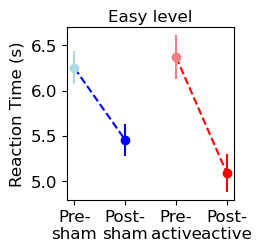

p_sham: 1.5971640991891811, p_active: 0.024257029618289013, p_pre: 3.4390274376461023, p_post: 0.3046072771189936
Pre-sham: 13.251488372093025 5.860764270150553 , Post-sham: 12.66272093023256 7.025936774487193 , Pre-active: 13.14149375 5.443543878965691 , Post-active: 11.41793567251462 5.879619177490006


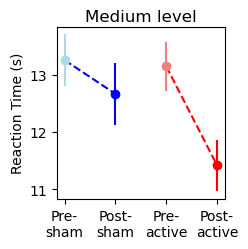

p_sham: 3.9690138278505733, p_active: 0.03289038127173381, p_pre: 3.766551398659774, p_post: 0.02749078156927251
Pre-sham: 32.846230769230765 19.144122072459833 , Post-sham: 32.82489864864865 18.303586185820713 , Pre-active: 32.68507092198581 17.8885782185351 , Post-active: 27.367507142857143 15.505547339881334


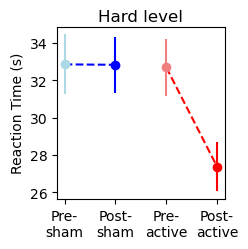

In [15]:
difficulties = choices
difficulty_names = ['Easy', 'Medium', 'Hard']
#                       pres,posts,prea,posta  
outliers_k1 = np.array([[5, 5, 5, 5], # low_k
                        [1, 5, 5, 5]]) # high_k
ourliers_k2 = np.array([[1.5, 5, 5, 5], 
                        [5, 5, 1.5, 5]])
outliers_k3 = np.array([[1, 1, 1, 5], 
                        [5, 5, 5, 1.2]])
outliers_ks = [outliers_k1, ourliers_k2, outliers_k3]
for difficulty in difficulties:
    subset_questions = rpm_difficulty[rpm_difficulty['difficulty'] == difficulty]
    # iterate "question" column of subset
    matching_rows = subjects_behavior[subjects_behavior['question'].isin(subset_questions['question'])]
    subset_rts = matching_rows[matching_rows['correct'] == 1]

    pre_sham_rts = subset_rts[(subset_rts['condition'] == 'Sham') & (subset_rts['task time'] == 'pre')]['reaction time']
    post_sham_rts = subset_rts[(subset_rts['condition'] == 'Sham') & (subset_rts['task time'] == 'post')]['reaction time']
    pre_active_rts = subset_rts[(subset_rts['condition'] == 'Active') & (subset_rts['task time'] == 'pre')]['reaction time']
    post_active_rts = subset_rts[(subset_rts['condition'] == 'Active') & (subset_rts['task time'] == 'post')]['reaction time']

    outlier_k = outliers_ks[difficulty-1]
    pre_sham_rts = funcs.remove_outliers(pre_sham_rts, low_k=outlier_k[0,0], high_k=outlier_k[1,0], verbose=False)
    post_sham_rts = funcs.remove_outliers(post_sham_rts, low_k=outlier_k[0,1], high_k=outlier_k[1,1], verbose=False)
    pre_active_rts = funcs.remove_outliers(pre_active_rts, low_k=outlier_k[0,2], high_k=outlier_k[1,2], verbose=False)
    post_active_rts = funcs.remove_outliers(post_active_rts, low_k=outlier_k[0,3], high_k=outlier_k[1,3], verbose=False)

    t_stat, p_sham = stats.ttest_ind(pre_sham_rts, post_sham_rts)
    t_stat, p_active = stats.ttest_ind(pre_active_rts, post_active_rts)
    t_stat, p_pre = stats.ttest_ind(pre_sham_rts, pre_active_rts)
    t_stat, p_post = stats.ttest_ind(post_sham_rts, post_active_rts)
    print(f'p_sham: {p_sham*4}, p_active: {p_active*4}, p_pre: {p_pre*4}, p_post: {p_post*4}')
    

    pre_sham_mean = pre_sham_rts.mean()
    post_sham_mean = post_sham_rts.mean()
    pre_active_mean = pre_active_rts.mean()
    post_active_mean = post_active_rts.mean()

    pre_sham_std = pre_sham_rts.std()
    post_sham_std = post_sham_rts.std()
    pre_active_std = pre_active_rts.std()
    post_active_std = post_active_rts.std()

    pre_sham_sem = pre_sham_rts.sem()
    post_sham_sem = post_sham_rts.sem()
    pre_active_sem = pre_active_rts.sem()
    post_active_sem = post_active_rts.sem()

    means = [pre_sham_mean, post_sham_mean, pre_active_mean, post_active_mean]
    stds = [pre_sham_std, post_sham_std, pre_active_std, post_active_std]
    sems = [pre_sham_sem, post_sham_sem, pre_active_sem, post_active_sem]

    fig_title = difficulty_names[difficulty-1] + " level"
    print('Pre-sham:', pre_sham_mean, pre_sham_std, ', Post-sham:', post_sham_mean, post_sham_std, ', Pre-active:', pre_active_mean, pre_active_std, ', Post-active:', post_active_mean, post_active_std)
    plot_reaction_times(means, stds, sems, fig_title)
    